# Analysis: Posteriors and Dynamical times

## 1. Develop the de-bias technique
## 2. Measure dynamical times in the MW halo

In [80]:

# basic imports
from __future__ import print_function
import numpy as np
from numpy.linalg import eig, inv
import time

# plotting elements
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
cmap = cm.RdBu_r


import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline
import scipy

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2


import reflexmotion.posteriorreader as pr
import reflexmotion.reflex as rm



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# make a rough outline of the BHB coverage (commensurate with SDSS coverage)
from reflexmotion import kde as kde_3d

X11 = np.genfromtxt('data/Xue2011BHB.txt',\
                        dtype={'names': ("RA","Dec","Glon","Glat",\
                                         "gmag","ug","gr","D0.2","fm",\
                                         "cHg","bHg","d","r",\
                                         "x","y","z","HRV",\
                                         "eHRV","Vgal","DR8","Sloan",\
                                         "SimbadName"),\
                             'formats': ('f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                         'S20')},\
                 skip_header=77,delimiter=';')

# unify coordinate systems
bhbl = X11['Glon']
bhbl[bhbl > 180.] -= 360.

bhbb = X11['Glat']

xx,yy,bhbw = kde_3d.total_kde_two(bhbl,-bhbb,\
                                       gridsize=256,\
                                       extents=(-179,179.,-89,89),\
                                       #extents=(0.,360.,-90,90),\
                                       #weights=PSPDump.mass/np.cos(halob),\
                                       ktype='gaussian',npower=6.)


#plt.contour(xx,yy,np.log10(bhbw),[-5.],colors='black')

## Make the Reflex Motion Model

In [64]:
from scipy.interpolate import RectBivariateSpline,interp2d

In [68]:
def haversine(lon1, lat1, lon2, lat2,deg=True):
    """
    Calculate the great circle distance between two points 
    on a sphere (specified in decimal degrees or radians)
    """
    # convert decimal degrees to radians 
    if deg:
        lon1, lat1, lon2, lat2 = (np.pi/180.)*lon1, (np.pi/180.)*lat1, (np.pi/180.)*lon2, (np.pi/180.)*lat2

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2. * np.arcsin(np.sqrt(a)) 
    if deg:
        return (180./np.pi)*c
    else:
        return c

In [123]:
ALL     = pr.read_posterior('/Users/mpetersen/Dropbox/mike/data/all_d040150_sgr20_L3000_cov.posteriors2')

ALL['vtravel']

array([15.33257551, 12.51216255, 36.95516299, ..., 28.20305246,
       28.03865383, 32.60584605])

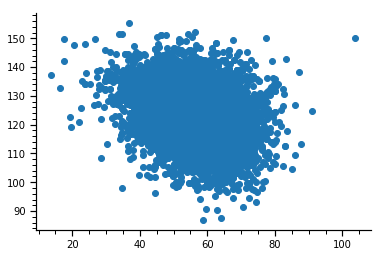

In [122]:
plt.scatter(ALL['phi'],90-ALL['theta'])

In [231]:
phi = 56.
theta = 90+34.
#phi = 0.
#theta = 0.
psi = 0.

twopi=False
travel='d'

pointres=40

l,b,dist,mul,mub,vlos = rm.make_model(phi,theta,psi=psi,pointres=pointres,travel=travel,flip=True)

l,b,xv,yv,zv = rm.make_model_cartesian(phi,theta,psi=psi,pointres=pointres,travel=travel,flip=True)




In [232]:
xv

array([0.46359193, 0.46359193, 0.46359193, ..., 0.46359193, 0.46359193,
       0.46359193])

In [129]:
b[100].astype('float16')
b.size

1600

In [91]:
sep = haversine(l, b, 0.0, 0.0,deg=False)
print(l[sep.argmin()],b[sep.argmin()],mub[sep.argmin()])

0.0 0.04027682889217665 0.00021077402045989612


In [268]:
phi = 90
theta = 90
l,b,xv,yv,zv = rm.make_model_cartesian(phi,theta,psi=psi,pointres=pointres,travel=travel,flip=True)
print(xv,yv,zv)


[6.123234e-17 6.123234e-17 6.123234e-17 ... 6.123234e-17 6.123234e-17
 6.123234e-17] [1. 1. 1. ... 1. 1. 1.] [6.123234e-17 6.123234e-17 6.123234e-17 ... 6.123234e-17 6.123234e-17
 6.123234e-17]


In [269]:
# print tables of model solutions

f = open('/Users/mpetersen/Downloads/PP20_correction_model_cartesian.txt','w')

nsamples = 2000

for n in range(0,nsamples):
    phi = ALL['phi'][n]
    theta = 90.-ALL['theta'][n]
    pointres=50
    travel='d'
    l,b,xv,yv,zv = rm.make_model_cartesian(phi,theta,psi=psi,pointres=pointres,travel=travel,flip=True)

    np.array([l,b,ALL['vtravel'][n]*xv,ALL['vtravel'][n]*yv,ALL['vtravel'][n]*zv]).astype('float16').tofile(f)

f.close()



In [200]:
# print tables of model solutions

f = open('/Users/mpetersen/Downloads/PP20_correction_model.txt','w')

nsamples = 2000

for n in range(0,nsamples):
    phi = ALL['phi'][n]
    theta = 90.-ALL['theta'][n]
    pointres=50
    travel='u'
    l,b,dist,mul,mub,vlos = rm.make_model(phi,theta,psi=psi,pointres=pointres,travel=travel,flip=True)

    np.array([l,b,ALL['vtravel'][n]*mul,ALL['vtravel'][n]*mub,ALL['vtravel'][n]*vlos]).astype('float16').tofile(f)

f.close()


In [240]:
#M = np.memmap('/Users/mpetersen/Downloads/PP20_correction_model.txt',dtype='float16',shape=(nsamples,5,pointres*pointres))


M = np.memmap('/Users/mpetersen/Downloads/PP20_correction_model_cartesian.txt',dtype='float16',shape=(nsamples,5,pointres*pointres))


print(M[nsamples-1,1,0:10])
print(b[0:10])

[0.8975 0.8975 0.8975 0.8975 0.8975 0.8975 0.8975 0.8975 0.8975 0.8975]
[0.89739814 0.89739814 0.89739814 0.89739814 0.89739814 0.89739814
 0.89739814 0.89739814 0.89739814 0.89739814]


In [307]:
def haversine(lon1, lat1, lon2, lat2,deg=True):
    """
    Calculate the great circle distance between two points 
    on a sphere (specified in decimal degrees or radians)
    """
    # convert decimal degrees to radians 
    if deg:
        lon1, lat1, lon2, lat2 = (np.pi/180.)*lon1, (np.pi/180.)*lat1, (np.pi/180.)*lon2, (np.pi/180.)*lat2

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2. * np.arcsin(np.sqrt(a)) 
    if deg:
        return (180./np.pi)*c
    else:
        return c
    

def draw_corrections_cartesian(lpos,bpos,M,ncorr=2000):
    """
    
    
    inputs
    -----------
    lpos  : in radians
    bpos  : in radians
    M
    ncorr
    
    
    """
    xcorr = np.zeros(ncorr)
    ycorr = np.zeros(ncorr)
    zcorr = np.zeros(ncorr)
    for n in range(0,ncorr):
        ntest = np.random.randint(0,M.shape[0])
        sep = haversine(M[ntest,0],M[ntest,1], lpos, bpos,deg=False)
        print((180./np.pi)*M[ntest,0,sep.argmin()],(180./np.pi)*M[ntest,1,sep.argmin()])
        xcorr[n]= M[ntest,2,sep.argmin()]
        ycorr[n]= M[ntest,3,sep.argmin()]
        zcorr[n]= M[ntest,4,sep.argmin()]
    return xcorr,ycorr,zcorr

In [305]:
M[6,3,0:20]

memmap([32.66, 32.66, 32.66, 32.66, 32.66, 32.66, 32.66, 32.66, 32.66,
        32.66, 32.66, 32.66, 32.66, 32.66, 32.66, 32.66, 32.66, 32.66,
        32.66, 32.66], dtype=float16)

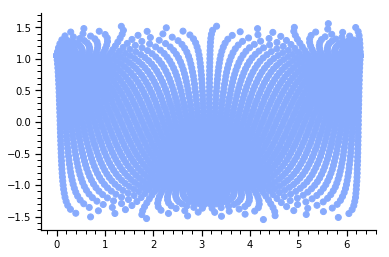

In [297]:
plt.scatter(M[0,0],M[0,1],color=cm.coolwarm((M[0,4]+25)/50.))

In [306]:
print(nsamples,pointres)
M = np.memmap('/Users/mpetersen/Downloads/PP20_correction_model_cartesian.txt',dtype='float16',shape=(nsamples,5,pointres*pointres))

xcorr,ycorr,zcorr = draw_corrections_cartesian(np.pi/2.,np.pi/4.,M,ncorr=10)
print(xcorr,zcorr)


2000 50
92.8818300700358 45.60162138980673
91.65086605705942 45.79745657368934
87.84606819876879 45.34983329624338
90.02823167631783 47.420090954430925
90.53180786344453 47.00044413182534
88.01392692781103 44.39863383167073
89.69251421823336 44.09089282842663
86.78296291483466 43.36350500257695
89.80442003759485 44.06291637358626
92.8818300700358 46.021268212412316
[-26.46875    -8.734375  -27.515625  -15.8125    -12.28125   -19.828125
 -10.2578125 -18.3125    -18.234375  -21.34375  ] [-26.46875    -8.734375  -27.515625  -15.8125    -12.28125   -19.828125
 -10.2578125 -18.3125    -18.234375  -21.34375  ]


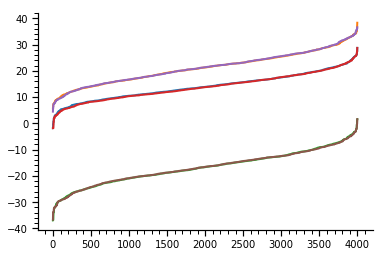

In [247]:
# read in the model uncertainty file
M = np.memmap('/Users/mpetersen/Downloads/PP20_correction_model_cartesian.txt',dtype='float16',shape=(nsamples,5,pointres*pointres))

xcorr,ycorr,zcorr = draw_corrections(np.pi/2.,np.pi,M,ncorr=4000)

plt.plot(xcorr[xcorr.argsort()])
plt.plot(ycorr[ycorr.argsort()])
plt.plot(zcorr[zcorr.argsort()])

xcorr,ycorr,zcorr = draw_corrections(0.0,0.0,M,ncorr=4000)

plt.plot(xcorr[xcorr.argsort()])
plt.plot(ycorr[ycorr.argsort()])
plt.plot(zcorr[zcorr.argsort()])



In [219]:
ntest = np.random.randint(0,1000)
ntest
M.shape

(2000, 5, 2500)

3.0565184291761325 0.8963532063506362 0.8021497716097021


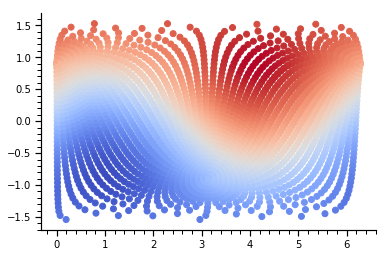

In [220]:
plt.scatter(l,b,color=cm.coolwarm(0.5*(vlos+1.)))


def draw_corrections(lpos,bpos,M,ncorr=2000):
    vloscorr = np.zeros(ncorr)
    mulcorr = np.zeros(ncorr)
    mubcorr = np.zeros(ncorr)
    for n in range(0,ncorr):
        ntest = np.random.randint(0,M.shape[0])
        sep = haversine(M[ntest,0],M[ntest,1], lpos, bpos,deg=False)
        mulcorr[n]= M[ntest,2,sep.argmin()]
        mubcorr[n]= M[ntest,3,sep.argmin()]
        vloscorr[n]= M[ntest,4,sep.argmin()]
    return mulcorr,mubcorr,vloscorr
        
        
mulcorr,mubcorr,vloscorr = draw_corrections(0.,0.,M,ncorr=2000)

print(l[sep.argmin()],b[sep.argmin()],vlos[sep.argmin()])


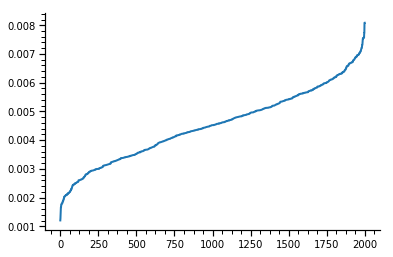

In [225]:
mulcorr,mubcorr,vloscorr = draw_corrections(0.,0.,M,ncorr=2000)

plt.plot(mulcorr[mulcorr.argsort()])

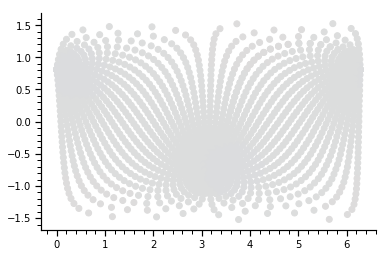

In [191]:
plt.scatter(M[99,0],M[99,1],color=cm.coolwarm(0.5*(M[99,3,:]+1.)))



In [ ]:
l

In [67]:
f = interp2d(l, b, vlos, kind='linear')



KeyboardInterrupt: 

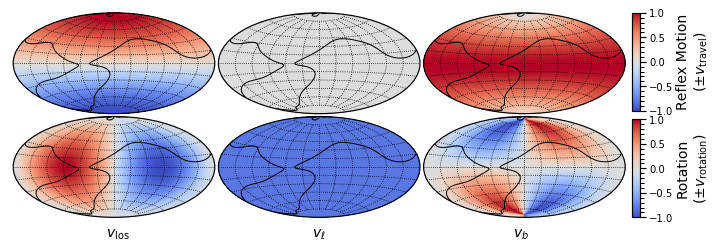

In [58]:
velstretch = np.linspace(-32,32,64)

# set up model 2

# pulled from the best-fit in the paper.
phi = 56.
theta = 90+34.
phi = 0.
theta = 0.
psi = 0.

twopi=False
travel='d'

pointres=50

fig = plt.figure(figsize=(10,4))
#ax = plt.subplot(111, projection="aitoff")
ax1 = fig.add_axes([0.0,0.56,0.3,0.35], projection="aitoff")
ax2 = fig.add_axes([0.285,0.56,0.3,0.35], projection="aitoff")
ax3 = fig.add_axes([0.57,0.56,0.3,0.35], projection="aitoff")
ax4 = fig.add_axes([0.0,0.2,0.3,0.35], projection="aitoff")
ax5 = fig.add_axes([0.285,0.2,0.3,0.35], projection="aitoff")
ax6 = fig.add_axes([0.57,0.2,0.3,0.35], projection="aitoff")

ax7 = fig.add_axes([0.87,0.57,0.01,0.34])
ax8 = fig.add_axes([0.87,0.2,0.01,0.34])


l,b,dist,mul,mub,vlos = rm.make_model(phi,theta,psi=psi,pointres=pointres,travel=travel,flip=True)
vel = vlos
velstretch = np.linspace(-1.,1.,64)
l[l>np.pi]-=2.*np.pi
ax1.scatter(-l,b,color=cm.coolwarm((vel-np.nanmin(velstretch))/(np.nanmax(velstretch)-np.nanmin(velstretch)),1.),s=20.)

vel = -rm.undo_proper_motion(mul,dist)
velstretch = np.linspace(-1.,1.,64)
l[l>np.pi]-=2.*np.pi
ax2.scatter(-l,b,color=cm.coolwarm((vel-np.nanmin(velstretch))/(np.nanmax(velstretch)-np.nanmin(velstretch)),1.),s=20.)

vel = rm.undo_proper_motion(mub,dist)
velstretch = np.linspace(-1.,1.,64)
l[l>np.pi]-=2.*np.pi
ax3.scatter(-l,b,color=cm.coolwarm((vel-np.nanmin(velstretch))/(np.nanmax(velstretch)-np.nanmin(velstretch)),1.),s=20.)

# make a rotation model; use a shortcut with the dipole model
phi = 90.
theta = 90.
l,b,dist,mul,mub,vlos = rm.make_model(phi,theta,psi=psi,pointres=pointres,travel=travel,flip=True)
vel = vlos
velstretch = np.linspace(-1.,1.,64)
l[l>np.pi]-=2.*np.pi
ax4.scatter(-l,b,color=cm.coolwarm((vel-np.nanmin(velstretch))/(np.nanmax(velstretch)-np.nanmin(velstretch)),1.),s=20.)

vel = -np.ones(mul.size)*0.8 # rescale slightly to fit in velocity
velstretch = np.linspace(-1.,1.,64)
l[l>np.pi]-=2.*np.pi
ax5.scatter(-l,b,color=cm.coolwarm((vel-np.nanmin(velstretch))/(np.nanmax(velstretch)-np.nanmin(velstretch)),1.),s=20.)

vel = rm.undo_proper_motion(mub,dist)
velstretch = np.linspace(-1.,1.,64)
l[l>np.pi]-=2.*np.pi
ax6.scatter(-l,b,color=cm.coolwarm((vel-np.nanmin(velstretch))/(np.nanmax(velstretch)-np.nanmin(velstretch)),1.),s=20.)


for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.grid(True,color='black',linestyle='dotted')
    ax.set_xticklabels(())
    ax.set_yticklabels(())
    ax.contour(-(np.pi/180.)*xx,(np.pi/180.)*yy,-np.log10(bhbw),[5.],colors='black',linewidths=1.)

plt.text(0.31/2.,     0.14,'$v_{\\rm los}$',size=14,transform=fig.transFigure,ha='center',va='center')
plt.text(0.31/2.+0.28,0.14,'$v_{\ell}$',size=14,transform=fig.transFigure,ha='center',va='center')
plt.text(0.31/2.+0.56,0.14,'$v_{b}$',size=14,transform=fig.transFigure,ha='center',va='center')


cmap = cm.magma; norm = mpl.colors.Normalize(vmin=-1., vmax=1.)
cb1 = mpl.colorbar.ColorbarBase(ax7, cmap=cm.coolwarm,norm=norm)
cb1.set_label('Reflex Motion\n($\pm v_{\\rm travel})$',size=14)
cb1.set_ticks(np.round(np.arange(-1.,1.01,0.5),1))

cmap = cm.magma; norm = mpl.colors.Normalize(vmin=-1., vmax=1.)
cb1 = mpl.colorbar.ColorbarBase(ax8, cmap=cm.coolwarm,norm=norm)
cb1.set_label('Rotation\n($\pm v_{\\rm rotation})$',size=14)
cb1.set_ticks(np.round(np.arange(-1.,1.01,0.5),1))




plt.savefig('figures/model_values0.png',dpi=300)




## Part 2: Dynamical Times in the MW halo

In [4]:
from reflexmotion import dynamicaltimes as dytime

[106.48577541  63.59417396   0.        ]
[111.34501141  56.8011989    0.        ]


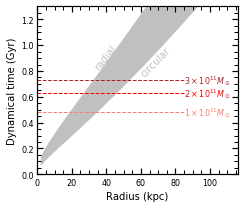

In [5]:
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
    
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8

mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True



model = dytime.make_sph_model_file('../Shells/SLGridSph.mw')

O = dytime.orbit()
O = dytime.make_orbit(O,-7.,0.9999,model)
O = dytime.compute_frequencies(O,model)

print(O.freq)

O = dytime.make_orbit(O,-7.,0.04,model)
O = dytime.compute_frequencies(O,model)

print(O.freq)

erange = np.linspace(0.95*np.nanmin(model.potcurve(model.rcurve)),1.1*np.nanmax(model.potcurve(model.rcurve)),100)

rfunc = UnivariateSpline(model.potcurve(model.rcurve),model.rcurve,s=0)
rrange = rfunc(erange)
frcirc = np.zeros(erange.size)
fpcirc = np.zeros(erange.size)
frrad = np.zeros(erange.size)
fprad = np.zeros(erange.size)

for ie,ee in enumerate(erange):

    # circular first
    O = dytime.make_orbit(O,ee,0.99,model)
    O = dytime.compute_frequencies(O,model)
    frcirc[ie] = O.freq[0]
    fpcirc[ie] = O.freq[1]
    
    # radial
    O = dytime.make_orbit(O,ee,.1,model)
    O = dytime.compute_frequencies(O,model)
    frrad[ie] = O.freq[0]
    fprad[ie] = O.freq[1]


fig = plt.figure(figsize=(3.5,3))
ax = fig.add_subplot(111)

ax.fill_between(300.*rrange,(2.2*(2.*np.pi)/frrad),(2.2*(2.*np.pi)/fpcirc),color='silver')


colorlist2 = ['salmon','red','firebrick']

# 1e11
ax.plot([0.,85.],[0.48,0.48],color=colorlist2[0],linestyle='dashed',lw=1.)
ax.text(112.,0.48,'$1\\times10^{11}M_\odot$',color=colorlist2[0],ha='right',va='center',size=8)


# 2e11
ax.plot([0.,85.],[0.63,0.63],color=colorlist2[1],linestyle='dashed',lw=1.)
ax.text(112.,0.63,'$2\\times10^{11}M_\odot$',color=colorlist2[1],ha='right',va='center',size=8)

# 3e11
ax.plot([0.,85.],[0.73,0.73],color=colorlist2[2],linestyle='dashed',lw=1.)
ax.text(112.,0.73,'$3\\times10^{11}M_\odot$',color=colorlist2[2],ha='right',va='center',size=8)

ax.text(32.,0.8,'radial',color='silver',size=10,rotation=52,ha='left',va='bottom')
ax.text(59.,1.0,'circular',color='silver',size=10,rotation=45,ha='left',va='top')

ax.set_xlabel('Radius (kpc)',size=10)
ax.set_ylabel('Dynamical time (Gyr)',size=10)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis="both",which='both',direction="in")

ax.axis([0.,116.,0.,1.3])
fig.tight_layout()
plt.savefig('figures/dynamical_time_estimates_new.png',dpi=300)

[106.48577541  63.59417396   0.        ]
[111.34501141  56.8011989    0.        ]


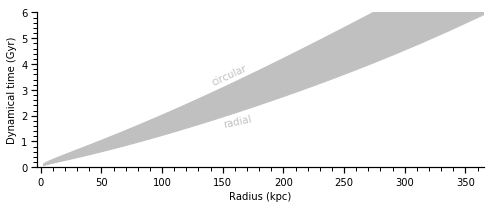

In [57]:

mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig = plt.figure(figsize=(7,3))

ax = fig.add_subplot(111)

prefac = 6/1.39

model = dytime.make_sph_model_file('../Shells/SLGridSph.mw')

O = dytime.orbit()
O = dytime.make_orbit(O,-7.,0.9999,model)
O = dytime.compute_frequencies(O,model)

print(O.freq)

O = dytime.make_orbit(O,-7.,0.04,model)
O = dytime.compute_frequencies(O,model)

print(O.freq)

erange = np.linspace(0.95*np.nanmin(model.potcurve(model.rcurve)),1.1*np.nanmax(model.potcurve(model.rcurve)),100)

rfunc = UnivariateSpline(model.potcurve(model.rcurve),model.rcurve,s=0)
rrange = rfunc(erange)
frcirc = np.zeros(erange.size)
fpcirc = np.zeros(erange.size)
frrad = np.zeros(erange.size)
fprad = np.zeros(erange.size)
orapo = np.zeros(erange.size)

for ie,ee in enumerate(erange):

    # circular first
    O = dytime.make_orbit(O,ee,0.99,model)
    O = dytime.compute_frequencies(O,model)
    frcirc[ie] = O.freq[0]
    fpcirc[ie] = O.freq[1]
    
    # radial
    try:
        O = dytime.make_orbit(O,ee,.01,model)
    except:
        O = dytime.make_orbit(O,ee,.1,model)
    O = dytime.compute_frequencies(O,model)
    orapo[ie] = O.r_apo
    frrad[ie] = O.freq[0]
    fprad[ie] = O.freq[1]


#fig = plt.figure(figsize=(3.5,3))
#ax = fig.add_subplot(111)

#ax.fill_between(300.*rrange,(2.2*(2.*np.pi)/frrad),(2.2*(2.*np.pi)/fpcirc),color='silver')


"""
# sun
ax.plot([(8.),(8.)],[0.0,prefac*0.45],color='black',lw=1.5)#,linestyle='dotted')
ax.text(8.,prefac*0.5,'solar radius',color='black',size=8,rotation=90,va='bottom',ha='center')
ax.plot([(8.),(8.)],[prefac*0.95,prefac*1.4],color='black',lw=1.5)#,linestyle='dotted')


# thin streams
ax.text(55.,prefac*0.99,'thin streams',color='white',size=8,rotation=0,va='bottom',ha='center')
ax.fill_between([10.,100.],[prefac*0.99,prefac*0.99],[prefac*1.08,prefac*1.08],color='black',alpha=0.7,lw=0.)

# smooth halo
ax.text(100.,prefac*1.09,'smooth halo',color='white',size=8,rotation=0,va='bottom',ha='center')
ax.fill_between([50.,150.],[prefac*1.09,prefac*1.09],[prefac*1.18,prefac*1.18],color='black',alpha=0.7,lw=0.)




# Sgr
ax.text(37.,prefac*1.2,'Sgr debris',color='white',size=8,rotation=0,va='bottom')

# trajectory bar
for b in range(0,100):
    ax.fill_between([35.,35+b],[prefac*1.2,prefac*1.2],[prefac*1.29,prefac*1.29],color='black',alpha=(1-b/100.)**1./30,lw=0.)


# LMC
ax.text(52.,prefac*1.31,'LMC trajectory',color='white',size=8,rotation=0,va='bottom')

# trajectory bar
for b in range(0,100):
    ax.fill_between([50.,50+2*b],[prefac*1.31,prefac*1.31],[prefac*1.4,prefac*1.4],color='black',alpha=(1-b/100.)**1./30,lw=0.)




for b in range(0,30):
    ax.fill_between([290.-1*b,290+1*b],[0.0,0.0],[prefac*1.4,prefac*1.4],color='black',alpha=(1-b/30.)**1./10,lw=0.)

ax.text(290.,prefac*0.3,'virial radius',color='white',size=8,rotation=90,va='bottom',ha='center')




# distance to M31? 725 kpc, what's halfway?
ax.plot([(362.5),(362.5)],[prefac*0.8,prefac*1.4],color='black',lw=1.5)#linestyle='dotted')
ax.plot([(362.5),(362.5)],[0.0,prefac*0.22],color='black',lw=1.5)#linestyle='dotted')
ax.text(362.5,prefac*0.8,'halfway to M31',color='black',size=8,rotation=90,va='top',ha='center')

"""

ax.fill_between(300.*rrange,(2.2*(1.75*np.pi)/frrad),(2.2*(2.*np.pi)/fpcirc),color='silver')
ax.text(140.,3.1,'circular',color='silver',size=10,rotation=24,ha='left',va='bottom')
ax.text(150.,2.1,'radial',color='silver',size=10,rotation=12,ha='left',va='top')




ax.set_xlabel('Radius (kpc)',size=10)
ax.set_ylabel('Dynamical time (Gyr)',size=10)

ax.axis([-3.,365.,0.,6.])
fig.tight_layout()
plt.savefig('figures/dynamical_orientation1.png',dpi=300)

5.755395683453238

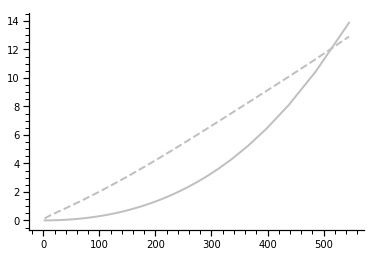

In [35]:
plt.plot(300.*rrange,(2.2*(4*orapo)/frrad),color='silver')
plt.plot(300.*rrange,(2.2*(2.*np.pi)/fpcirc),color='silver',linestyle='dashed')




## Part 3: Softening in the model

In [6]:
# try first in virial

def plummer_circ(core,satmass,rtest=np.linspace(0.001,1.0,1000)):

    fac = rtest*rtest + core*core
    fac = np.power(fac, -0.5)
    ffac = -satmass*fac*fac*fac
    rforce = ffac*(rtest)
    vcirc = np.sqrt(rtest*-rforce)
    
    return rtest,vcirc


dscale = 300.
vscale = 220./1.45
mscale = 1./16.4
core = 0.04 
satmass = 1.*mscale



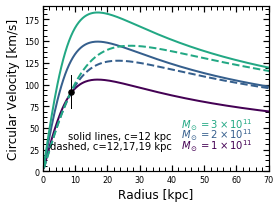

In [7]:
# try first in virial

fig = plt.figure(figsize=(4,3))

ax = fig.add_subplot(111)

dscale = 300.
vscale = 200./1.45
mscale = 1./16.4

core = 0.04 
satmass = 1.*mscale
rtest,vcirc = plummer_circ(core,satmass)
ax.plot(dscale*rtest,vscale*vcirc,color=cm.viridis(0.0,1.))

core = 0.04
satmass = 2.*mscale
rtest,vcirc = plummer_circ(core,satmass)
ax.plot(dscale*rtest,vscale*vcirc,color=cm.viridis(0.3,1.))

core = 0.055
satmass = 2.*mscale
rtest,vcirc = plummer_circ(core,satmass)
ax.plot(dscale*rtest,vscale*vcirc,color=cm.viridis(0.3,1.),linestyle='dashed')

core = 0.04 
satmass = 3.*mscale
rtest,vcirc = plummer_circ(core,satmass)
ax.plot(dscale*rtest,vscale*vcirc,color=cm.viridis(0.6,1.))

core = 0.064 
satmass = 3.*mscale
rtest,vcirc = plummer_circ(core,satmass)
ax.plot(dscale*rtest,vscale*vcirc,color=cm.viridis(0.6,1.),linestyle='dashed')



ax.axis([0.,70.,0.,190.])

# lines
ax.scatter([8.7],[91.7],color='black',s=30.,zorder=10)
ax.plot([8.7,8.7],[91.7-18.8,91.7+18.8],color='black',lw=1.)

ax.set_xlabel('Radius [kpc]',size=12)
ax.set_ylabel('Circular Velocity [km/s]',size=12)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis="both",which='both',direction="in")


ax.text(65.,50.,'$M_\odot=3\\times10^{11}$',color=cm.viridis(0.6,1.),ha='right')
ax.text(65.,37.5,'$M_\odot=2\\times10^{11}$',color=cm.viridis(0.3,1.),ha='right')
ax.text(65.,25.,'$M_\odot=1\\times10^{11}$',color=cm.viridis(0.0,1.),ha='right')

ax.text(40.,37.5,'solid lines, c=12 kpc',color='black',ha='right')
ax.text(40.,25.,'dashed, c=12,17,19 kpc',color='black',ha='right')



plt.tight_layout()
plt.savefig('figures/LMC_model_comparison.png',dpi=300)


In [8]:

# from the trajectory file
tlmc, xlmc, ylmc, zlmc  = 0.0,    12.78, -39.22, -28.01
tlmc2,xlmc2,ylmc2,zlmc2 = 0.0044, 12.23, -40.26, -26.88

vxlmc = (xlmc2-xlmc)/tlmc2
vylmc = (ylmc2-ylmc)/tlmc2
vzlmc = (zlmc2-zlmc)/tlmc2

llmc = np.arctan2(ylmc,xlmc)
blmc = np.arccos(zlmc/np.sqrt(xlmc*xlmc+ylmc*ylmc+zlmc*zlmc))
print((180./np.pi)*llmc,90.-(180./np.pi)*blmc)
print(vxlmc,vylmc,vzlmc)

# true LMC
# 080.8942 -69.7561

-71.95158537710576 -34.17789406303237
-124.99999999999974 -236.36363636363615 256.8181818181824
